# Capstone Project - The Battle of Neighborhoods  

### Analysis and Recommendations - Coffee shops in New York City  

*Hima Bindu Battapati*

### INTRODUCTION

***The brief history and the introduction of Coffee to the New York City.***  
*Sources:  
https://stories.starbucks.com/stories/2018/a-brief-history-of-starbucks-in-new-york/  
          https://www.pbs.org/food/the-history-kitchen/history-coffee/*

Ever since the first barrels of coffee arrived from Dutch sailing ships in New Amsterdam, New York City has been at the epicenter of coffee culture and commerce.

When coffee first arrived in Manhattan in the mid-1600s, it was a rare luxury enjoyed by just a privileged few. But as the colonies chafed against British rule, the tide began to turn from tea to coffee.

*Coffee as an act of patriotism:*    
 Coffee plants reached the New World during the early 18th century, though the drink wasn't really popular in America until the Boston Tea Party of 1773, when making the switch from tea to coffee became something of a patriotic duty. The Civil War and other conflicts that followed also helped to increase coffee consumption, as soldiers relied on the caffeine for a boost of energy. It may have started a bit later here, but Americans love coffee just as much as the rest of the world.

By the early 1800s, the city was on its way to becoming the new nation’s coffee capital. The southern tip of Manhattan became known as the Coffee District. Its cobblestone streets were lined with brokers’ offices, who would bid on samples of green, unroasted coffee fetched by errand boys from ships docked nearby. By the late 1800s, the buying and selling of coffee became more formalized with the creation of the Coffee Exchange on Pearl Street in 1882.


“Before downtown rents spiked, lower Manhattan was constantly enveloped in the aroma of roasting coffee,” according to Meister’s book.

The city’s immigrants also influenced the way the beverage was enjoyed by its inhabitants. There were British clubhouses with curtained booths, Viennese-style coffee shops with marble counters and German bakeries that paired coffee with a sweet.

Coffee is fueling the city that never sleeps. 

By the 20th century, coffee kept the city buzzing. Coffee was everywhere. Brewed coffee was a staple of diners, bodegas and automats. There was also high-end coffee if you knew where to look. One of America’s first espresso machines served espresso in Greenwich Village starting in 1927.

As now we know how significant is coffee in the American Culture, and initially Manhattan was the Coffee District,  in this project we would like to explore a place/borough which has a maximum number of coffee shops and recommend a place/borough to a client who is interested to start a new Coffee shop.

### DATA SOURCES

* In order to answer the above questions, we need the data for New York City neighborhoods, boroughs to include boundaries, latitude, longitude, coffee shops, and ratings and tips.

* New York City data containing the Neighborhoods and Boroughs, Latitudes, and Longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

* New York City data containing Neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

* All data related to locations and quality of Coffee shops will be obtained via the FourSquare API through the 'Request' library in Python.

### METHODOLOGY

* Data will be collected from https://cocl.us/new_york_dataset, cleaned and processed into a dataframe.

* FourSquare API will be used to locate all venues and then filtered by Coffee shops. Ratings, tips, and likes by users will be counted and added to the dataframe.

* Data will be sorted based on rankings.

* Finally, the data be will be visually assessed using graphing from various Python libraries.

### Queries that can be answered by the end of this project
* Which borough has the highest number of coffee shops in NYC?

* In which Neighborhood and/or borough should I recommend for a Coffee shop to have the best chance of being successful?



***Let's start by loading the libraries.***

In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    certifi-2019.11.28         |   py36h9f0ad1d_1         149 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

***Define a function to get the geocodes i.e., latitude and longitude of a given location.***

In [4]:
def geo_location(address):
    
    # get geo location of address
    
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

##### Define a function to interact with FourSquare API and get the venues within a radius for a given latitude and longitude. 
##### The following function will return the Venue ID , Venue Name and Category.

In [5]:
def get_venues(lat,lng):
    
    
    radius=1000
    LIMIT=100
    CLIENT_ID = 'GZZ23IKP2ITFCTPWEB4Z25SMB5NBR3UKV3FDVAOGVBXGQVF4' # Foursquare CLIENT ID
    CLIENT_SECRET = 'AUYAHBW4ZCX31TENGLNT0NMRVLQVLKVDJGJJ5KKGHA4BCHHH' # Foursquare CLIENT SECRET
    VERSION = '20200402' # Foursquare API Version
    
    #url to fetch data from Foursquare API
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

***Define a function to get the details like 'Likes'  , 'Rating' , 'Tips' for a Particular venue which can be used for Ranking.***

In [6]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'GZZ23IKP2ITFCTPWEB4Z25SMB5NBR3UKV3FDVAOGVBXGQVF4' # Foursquare CLIENT ID
    CLIENT_SECRET = 'AUYAHBW4ZCX31TENGLNT0NMRVLQVLKVDJGJJ5KKGHA4BCHHH' # Foursquare CLIENT SECRET
    VERSION = '20200402' # Foursquare API version
    
    #url to fetch data from Foursquare API
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

###### Define a funtion to obtain the New york City data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

###### By using the above defined function, we can retrieve the New york City data 

In [8]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

*OBSERVATION: There are 306 Neighborhoods in New york City.*

***Let's visualize the number of Neighborhoods in each Borough***

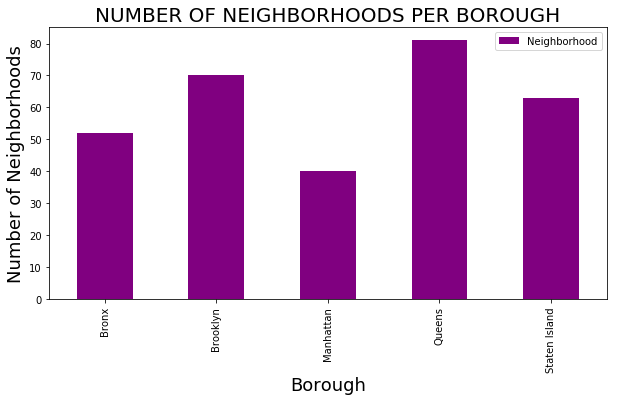

In [10]:
plt.figure(figsize=(10,5))
# title
plt.title('NUMBER OF NEIGHBORHOODS PER BOROUGH', fontsize = 20)
#On x-axis
plt.xlabel('Boroughs', fontsize = 18)
#On y-axis
plt.ylabel('Number of Neighborhoods', fontsize=18)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar', color = 'purple')
#legend
plt.legend()
#displays the plot
plt.show()

*OBSERVATION: Queens has the highest number of Boroughs in NYC.*

***Now let's gather the data for the total number of Coffee shops in each Neighborhood for all the Boroughs in NYC.***

In [10]:
# List of Coffee Shops in each Neighborhood in all the Boroughs in NYC
column_names=['Borough', 'Neighborhood', 'ID','Name']
coffee_shop_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    coffee_shops=venues[venues['Category']=='Coffee Shop']   
    print('(',count,'/',len(new_york_data),')','Coffee shops in '+Neighborhood+', '+Borough+':'+str(len(coffee_shops)))
    for shop_detail in coffee_shops.values.tolist():
        id, name , category=shop_detail
        coffee_shop_ny = coffee_shop_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Coffee shops in Wakefield, Bronx:0
done
( 2 / 306 ) Coffee shops in Co-op City, Bronx:1
done
( 3 / 306 ) Coffee shops in Eastchester, Bronx:0
done
( 4 / 306 ) Coffee shops in Fieldston, Bronx:1
done
( 5 / 306 ) Coffee shops in Riverdale, Bronx:2
done
( 6 / 306 ) Coffee shops in Kingsbridge, Bronx:4
done
( 7 / 306 ) Coffee shops in Marble Hill, Manhattan:2
done
( 8 / 306 ) Coffee shops in Woodlawn, Bronx:0
done
( 9 / 306 ) Coffee shops in Norwood, Bronx:1
done
( 10 / 306 ) Coffee shops in Williamsbridge, Bronx:0
done
( 11 / 306 ) Coffee shops in Baychester, Bronx:1
done
( 12 / 306 ) Coffee shops in Pelham Parkway, Bronx:2
done
( 13 / 306 ) Coffee shops in City Island, Bronx:0
done
( 14 / 306 ) Coffee shops in Bedford Park, Bronx:2
done
( 15 / 306 ) Coffee shops in University Heights, Bronx:0
done
( 16 / 306 ) Coffee shops in Morris Heights, Bronx:0
done
( 17 / 306 ) Coffee shops in Fordham, Bronx:4
done
( 18 / 306 ) Coffee shops in East Tremont, Bronx:1
done
( 19 / 306 

In [ ]:
coffee_shop_ny.shape

In [12]:
coffee_shop_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Co-op City,4eb4295c469073bbc596ef81,Starbucks
1,Bronx,Fieldston,4e7ba557dab43826d2a85f72,Starbucks
2,Bronx,Riverdale,49d73e8ff964a5201f5d1fe3,Starbucks
3,Bronx,Riverdale,4e7ba557dab43826d2a85f72,Starbucks
4,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine


In [13]:
coffee_shop_ny.tail()

,Borough,Neighborhood,ID,Name
547,Queens,Queensbridge,599eb7c1d8fe7a509b5b12e2,Clever Blend Lic
548,Queens,Queensbridge,53da26f3498ee77dff9cca9a,The Mill Coffee Company
549,Queens,Queensbridge,4f454b39e4b0b7292f7726b3,Triple Shot World Atlas
550,Queens,Queensbridge,5d45eb8657df850008a2715d,Starbucks
551,Queens,Queensbridge,4b0807abf964a520890223e3,Starbucks


*OBSERVATION: There are 552 coffee shops in all in NYC.*

***Let's visualize the number of Coffee Shops in each Borough in NYC.***

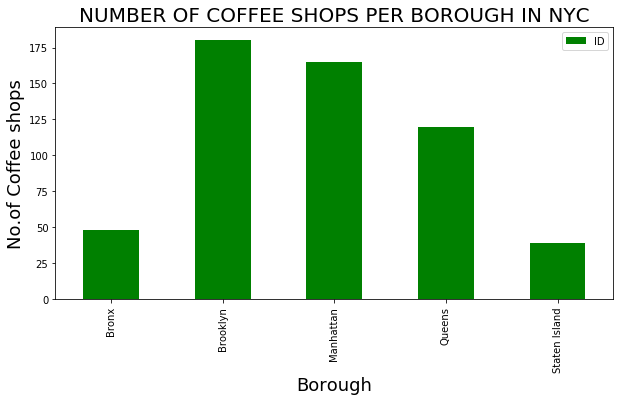

In [14]:
plt.figure(figsize=(10,5))
# title
plt.title('NUMBER OF COFFEE SHOPS PER BOROUGH IN NYC', fontsize = 20)
#On x-axis
plt.xlabel('Borough', fontsize = 18)
#On y-axis
plt.ylabel('No.of Coffee shops', fontsize=18)
#giving a bar plot
coffee_shop_ny.groupby('Borough')['ID'].count().plot(kind='bar', color = 'green')
#legend
plt.legend()
#displays the plot
plt.show()

*OBSERAVATION: Brooklyn has the highest number of Coffee Shops in NYC.*

***Let's visualize the number of Coffee Shops in the Neighborhoods in NYC.  
We have chosen the 5 Neighborhoods with maximum number of Coffee shops in NYC.***

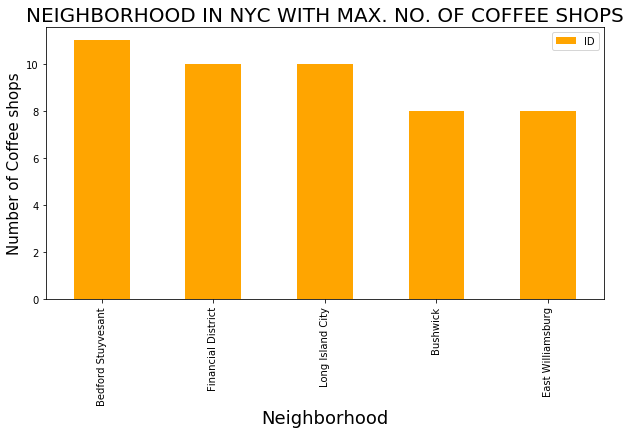

In [15]:
plt.figure(figsize=(10,5))
# title
plt.title('NEIGHBORHOOD IN NYC WITH MAX. NO. OF COFFEE SHOPS', fontsize = 20)
#On x-axis
plt.xlabel('Neighborhood', fontsize = 18)
#On y-axis
plt.ylabel('Number of Coffee shops', fontsize=15)
#giving a bar plot
coffee_shop_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar', color = 'orange')
#legend
plt.legend()
#displays the plot
plt.show()


*OBSERVATION: Bedford Stuyvesant Neighborhood in Brooklyn has the highest number of Coffee Shops in NYC.*

In [16]:
coffee_shop_ny[coffee_shop_ny['Neighborhood']=='Bedford Stuyvesant']

,Borough,Neighborhood,ID,Name
92,Brooklyn,Bedford Stuyvesant,589f51079343e07629090fb6,Little Roy Coffee Co.
93,Brooklyn,Bedford Stuyvesant,56bf7516cd1024b6713b3563,Brooklyn Kettle
94,Brooklyn,Bedford Stuyvesant,56d34672cd10d6b76e3dc455,Nostrand
95,Brooklyn,Bedford Stuyvesant,4d0d29f195c1a1cdfdac00ff,Cinnamon Girl
96,Brooklyn,Bedford Stuyvesant,5662f5d3498e53d321cd3456,"S,T Coffee"
97,Brooklyn,Bedford Stuyvesant,572e0e7f498ef0f740dd8229,BoHaus Coffee and Flowers
98,Brooklyn,Bedford Stuyvesant,55e47f46498e87452e04a281,Willoughby General
99,Brooklyn,Bedford Stuyvesant,52a102da11d29a428cb564e7,Crocus Coffee
100,Brooklyn,Bedford Stuyvesant,5ba95edefe3740002cde5b78,Żabka Coffee
101,Brooklyn,Bedford Stuyvesant,54550e00498efbb0dc34de7a,Burly Coffee


***Let's obtain the Ranking for each Coffee Shop for further analysis.***

In [17]:

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
coffee_shop_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in coffee_shop_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these shops as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(coffee_shop_ny),')','processed')
    coffee_shop_stats_ny = coffee_shop_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID       Name  Likes  Rating  Tips
0  4eb4295c469073bbc596ef81  Starbucks     14     7.2     3
( 1 / 552 ) processed
                         ID       Name  Likes  Rating  Tips
0  4e7ba557dab43826d2a85f72  Starbucks      8     6.6     4
( 2 / 552 ) processed
                         ID       Name  Likes  Rating  Tips
0  49d73e8ff964a5201f5d1fe3  Starbucks     67     7.1    64
( 3 / 552 ) processed
                         ID       Name  Likes  Rating  Tips
0  4e7ba557dab43826d2a85f72  Starbucks      8     6.6     4
( 4 / 552 ) processed
                         ID                     Name  Likes  Rating  Tips
0  5660c06b498e4003dba169a5  Mon Amour Coffee & Wine     22     8.4     7
( 5 / 552 ) processed
                         ID       Name  Likes  Rating  Tips
0  55f81cd2498ee903149fcc64  Starbucks     24     8.0     2
( 6 / 552 ) processed
                         ID       Name  Likes  Rating  Tips
0  49d73e8ff964a5201f5d1fe3  Starbucks     67     7.1    64


KeyError: 'venue'

In [18]:
coffee_shop_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,4eb4295c469073bbc596ef81,Starbucks,14,7.2,3
1,Bronx,Fieldston,4e7ba557dab43826d2a85f72,Starbucks,8,6.6,4
2,Bronx,Riverdale,49d73e8ff964a5201f5d1fe3,Starbucks,67,7.1,64
3,Bronx,Riverdale,4e7ba557dab43826d2a85f72,Starbucks,8,6.6,4
4,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine,22,8.4,7


So we got data for all coffee shops.
Now let's save this data to a csv file as the number of calls to get details for venue are premium calls and have limit of 500 per day, we will refer to saved csv file if required.

In [ ]:
coffee_shop_stats_ny.to_csv('coffee_shop_stats_ny.csv', index=False)

Lets verify the data from saved csv file

In [ ]:
coffee_shop_stats_ny_csv=pd.read_csv('coffee_shop_stats_ny.csv')

In [21]:
coffee_shop_stats_ny_csv.shape

(500, 7)

In [22]:
coffee_shop_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,4eb4295c469073bbc596ef81,Starbucks,14,7.2,3
1,Bronx,Fieldston,4e7ba557dab43826d2a85f72,Starbucks,8,6.6,4
2,Bronx,Riverdale,49d73e8ff964a5201f5d1fe3,Starbucks,67,7.1,64
3,Bronx,Riverdale,4e7ba557dab43826d2a85f72,Starbucks,8,6.6,4
4,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine,22,8.4,7


In [23]:
coffee_shop_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
Borough         500 non-null object
Neighborhood    500 non-null object
ID              500 non-null object
Name            500 non-null object
Likes           500 non-null object
Rating          500 non-null float64
Tips            500 non-null object
dtypes: float64(1), object(6)
memory usage: 27.4+ KB


We see that values like 'Likes', 'Tips' are string values. We would need to convert them into float for further analysis

In [24]:
coffee_shop_stats_ny['Likes']=coffee_shop_stats_ny['Likes'].astype('float64')

In [25]:
coffee_shop_stats_ny['Tips']=coffee_shop_stats_ny['Tips'].astype('float64')

In [26]:
coffee_shop_stats_ny['Rating']=coffee_shop_stats_ny['Rating'].astype('float64')

In [27]:
coffee_shop_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
Borough         500 non-null object
Neighborhood    500 non-null object
ID              500 non-null object
Name            500 non-null object
Likes           500 non-null float64
Rating          500 non-null float64
Tips            500 non-null float64
dtypes: float64(3), object(4)
memory usage: 27.4+ KB


Now the data types look correct

In [28]:
# Shop with maximum number of 'Likes'
coffee_shop_stats_ny.iloc[coffee_shop_stats_ny['Likes'].idxmax()]

Borough                         Manhattan
Neighborhood                Midtown South
ID               4aa52d50f964a520834720e3
Name            Stumptown Coffee Roasters
Likes                                2445
Rating                                  9
Tips                                  691
Name: 463, dtype: object

In [29]:
# Shops with maximum Customer Rating
coffee_shop_stats_ny.iloc[coffee_shop_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood             Carroll Gardens
ID              5b2aa0d02619ee002c85184e
Name                       nerd be cool.
Likes                                 50
Rating                               9.4
Tips                                   7
Name: 114, dtype: object

In [30]:
# Shops with maximum Tips from Customers
coffee_shop_stats_ny.iloc[coffee_shop_stats_ny['Tips'].idxmax()]

Borough                         Manhattan
Neighborhood                Midtown South
ID               4aa52d50f964a520834720e3
Name            Stumptown Coffee Roasters
Likes                                2445
Rating                                  9
Tips                                  691
Name: 463, dtype: object

In [31]:
ny_neighborhood_stats=coffee_shop_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
115,Noho,9.000000
144,Soho,9.000000
72,Greenwich Village,9.000000
28,Chinatown,8.933333
103,Midtown,8.925000
104,Midtown South,8.925000
95,Lower East Side,8.900000
91,Little Italy,8.900000
158,Tribeca,8.875000
155,Sutton Place,8.875000


Above are the top neighborhoods with top average rating of Coffee Shops

In [32]:
ny_borough_stats=coffee_shop_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.480745
1,Brooklyn,8.005660
3,Queens,7.262136
4,Staten Island,7.114286
0,Bronx,6.685714


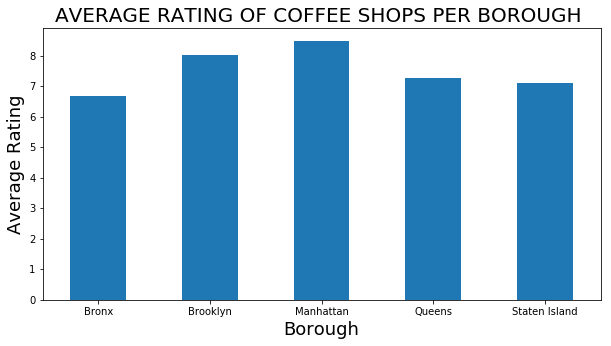

In [33]:
coffee_shop_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('AVERAGE RATING OF COFFEE SHOPS PER BOROUGH ', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 18)
#On y-axis
plt.ylabel('Average Rating', fontsize=18)
plt.xticks(rotation = 'horizontal')
plt.show()

***We will consider all the neighborhoods with average rating greater or equal 7.0 to visualize on map.***

In [34]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [35]:
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Arverne,8.300000
3,Astoria,8.140000
4,Auburndale,7.300000
5,Bath Beach,7.433333
6,Battery Park City,8.700000
7,Bay Ridge,7.933333
9,Baychester,7.200000
10,Bayside,7.550000
12,Bedford Stuyvesant,7.700000
13,Bellerose,7.800000


***We will join this dataset to original New York data to get longitudes and latitudes.***

In [36]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [37]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [38]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Arverne,40.589144,-73.791992,8.300000
1,Queens,Astoria,40.768509,-73.915654,8.140000
2,Queens,Auburndale,40.761730,-73.791762,7.300000
3,Brooklyn,Bath Beach,40.599519,-73.998752,7.433333
4,Manhattan,Battery Park City,40.711932,-74.016869,8.700000
5,Brooklyn,Bay Ridge,40.625801,-74.030621,7.933333
6,Bronx,Baychester,40.866858,-73.835798,7.200000
7,Queens,Bayside,40.766041,-73.774274,7.550000
8,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,7.700000
9,Queens,Bellerose,40.728573,-73.720128,7.800000


Now we will show this data on a map

In [39]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [40]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [41]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [ ]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

***Lets visualize the Boroughs based on Average Rating***

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='PuBu', #'YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)
# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

### Results / Conclusion

Manhattan and Brooklyn have the best rated Coffee shops on average. However, note, Bedford Stuyvesant of Brooklyn is the neighborhood in all of NYC with the highest number of Coffee shops. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the best rated coffee shops. Based on this information, I would state that Manhattan and Brooklyn are the best locations for coffee shops in NYC. 

To have the best shot of success, I would recommend to open a coffee shop in Queens. Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of coffee shops when compared to Manhattan or Brooklyn, making competition easier than in other boroughs. 

As a final note, all of the above analysis is depended on the adequacy and accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.

### Limitations

* The ranking is purely on basis of rating of coffee shops.
* The accuracy of data depends purely depends on the data provided by FourSquare.